In [ ]:
import pandas as pd
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from scipy import stats
from arch import arch_model

In [7]:
prices = pd.read_csv("/Users/tj_zhang/Library/CloudStorage/OneDrive-SaïdBusinessSchool/1 FE/FE PW4/mfe-practical-work-4-2024-2025.csv.gz", compression="infer")
prices["timestamp"] = pd.to_datetime(prices.timestamp)
prices = prices.set_index("timestamp")

In [11]:
print(prices.head(15))
print("...")
print(prices.tail(15))

                      price
timestamp                  
2014-05-01 09:30:00  131.32
2014-05-01 09:30:01  131.30
2014-05-01 09:30:02  131.30
2014-05-01 09:30:03  131.31
2014-05-01 09:30:04  131.31
2014-05-01 09:30:05  131.30
2014-05-01 09:30:06  131.31
2014-05-01 09:30:07  131.31
2014-05-01 09:30:08  131.31
2014-05-01 09:30:09  131.31
2014-05-01 09:30:10  131.30
2014-05-01 09:30:11  131.31
2014-05-01 09:30:12  131.32
2014-05-01 09:30:13  131.31
2014-05-01 09:30:14  131.31
...
                      price
timestamp                  
2023-12-27 15:59:46  283.61
2023-12-27 15:59:47  283.60
2023-12-27 15:59:48  283.60
2023-12-27 15:59:49  283.58
2023-12-27 15:59:50  283.61
2023-12-27 15:59:51  283.60
2023-12-27 15:59:52  283.58
2023-12-27 15:59:53  283.58
2023-12-27 15:59:54  283.57
2023-12-27 15:59:55  283.57
2023-12-27 15:59:56  283.59
2023-12-27 15:59:57  283.61
2023-12-27 15:59:58  283.62
2023-12-27 15:59:59  283.61
2023-12-27 16:00:00  283.61


# Q1

In [ ]:
prices['r'] = np.log(prices['price']).diff()

# Compute squared log-returns
prices['r^2'] = prices['r'] ** 2

# Group by trading day (adjust depending on your trading hours) and sum the squared returns
daily_rv = prices['r^2'].groupby(prices.index.date).sum()

# For example, to compute daily realized volatility:
daily_rsd = np.sqrt(daily_rv)

daily_rv.head()


2014-05-01    0.000145
2014-05-02    0.000249
2014-05-05    0.000255
2014-05-06    0.000260
2014-05-07    0.000156
Name: r^2, dtype: float64

# Q2

/var/folders/xt/cdq2n48x6kdbd0pjyzbk0s3h0000gn/T/ipykernel_79958/3045955667.py:7: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  resampled_p = prices['price'].resample(f'{i}T').last().dropna()


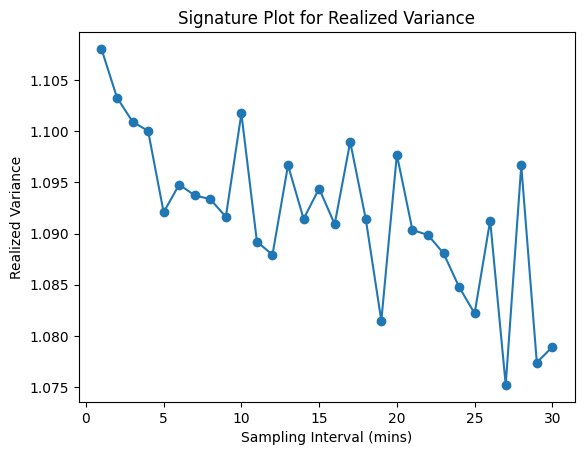

In [20]:
# Define the sampling intervals in minutes
intervals =  list(range(1, 31))
rv_estimates = []

for i in intervals:
    # Resample the data at the given interval using the last observed price
    resampled_p = prices['price'].resample(f'{i}T').last().dropna()
    
    # Compute log returns
    log_r = np.diff(np.log(resampled_p))
    
    # Compute realized variance as the sum of squared log returns
    rv = np.sum(log_r ** 2)
    rv_estimates.append(rv)

# Plot the signature plot
plt.plot(intervals, rv_estimates, marker='o')
plt.xlabel('Sampling Interval (mins)')
plt.ylabel('Realized Variance')
plt.title('Signature Plot for Realized Variance')
plt.show()

# Q3

In [ ]:
# realized_variance should be list of RV with the optimal frequency we picked

# below are chatgpt's answer

# start with taking ln RV, then plot residuals to see if residual is normal, if not normal, model RV instead

interval = 14  # Optimal interval is 14 minutes
prices_resampled = prices['price'].resample(f'{interval}T').last().dropna()

# Convert to DataFrame for grouping
prices_resampled = prices_resampled.to_frame()

# Extract the date part for grouping
prices_resampled['date'] = prices_resampled.index.date

# Compute the log return within each date group
log_returns = np.log(prices_resampled.groupby('date')['price']).diff()

# Drop NaN values that result from the first difference in each group
log_returns.dropna(inplace=True)

# Compute squared log returns (Realized Variance)
rv = log_returns ** 2

# Sum squared returns within each day to get daily RV
daily_rv = rv.groupby(prices_resampled.index.date).sum()

rv_df = pd.DataFrame(daily_rv, columns=['RV'])

rv_df['RV_1'] = rv_df['RV'].shift(1)  # 1-day lag
rv_df['RV_5'] = rv_df['RV'].rolling(window=5).mean().shift(1)  # 5-day rolling mean, shifted
rv_df['RV_22'] = rv_df['RV'].rolling(window=22).mean().shift(1)  # 22-day rolling mean, shifted

# ln variables
rv_df['ln_RV'] = np.log(rv_df['RV'])
rv_df['ln_RV_1'] = np.log(rv_df['RV_1'])
rv_df['ln_RV_5'] = np.log(rv_df['RV_5'])
rv_df['ln_RV_22'] = np.log(rv_df['RV_22'])

# Drop missing values due to lagging
rv_df = rv_df.dropna()

# Define dependent (Y) and independent (X) variables
y = rv_df['ln_RV']
X = rv_df[['ln_RV_1', 'ln_RV_5', 'ln_RV_22']]

# 2. Split data into training (50%) and testing (50%) sets
split_index = int(len(daily_rv) * 0.5)
train_data = daily_rv[:split_index]  # 50% for training
test_data = daily_rv[split_index:]  # 50% for testing

# 3. Construct HAR model
X = sm.add_constant(X)

# Fit the OLS regression model
har_model = sm.OLS(y, X).fit()

# Print results
print(har_model.summary())

# 4. Make predictions and evaluate performance
pred_1 = har_model.predict(sm.add_constant(pd.concat([train_data.shift(i) for i in range(1, 2)], axis=1)))

# For evaluation, you can calculate RMSE or any other relevant metric
from sklearn.metrics import mean_squared_error
rmse_1 = np.sqrt(mean_squared_error(test_data[:len(pred_1)], pred_1))
rmse_5 = np.sqrt(mean_squared_error(test_data[:len(pred_5)], pred_5))
rmse_22 = np.sqrt(mean_squared_error(test_data[:len(pred_22)], pred_22))

print(f'RMSE for 1-lag HAR model: {rmse_1}')
print(f'RMSE for 5-lag HAR model: {rmse_5}')
print(f'RMSE for 22-lag HAR model: {rmse_22}')

In [1]:
# plot residual to see whether to log

residuals = har_model.resid

plt.figure(figsize=(12, 6))
plt.plot(residuals, label="Residuals", color='blue')
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)
plt.title("Residuals of HAR Model")
plt.xlabel("Time")
plt.ylabel("Residual")
plt.legend()
plt.show()

NameError: name 'har_model' is not defined

# Q4

In [ ]:
# If asymmetry is significant, use GJR-GARCH(1,1,1).

# Use daily close-to-close log returns
daily_returns = np.log(prices["price"].resample("1D").last()).diff().dropna()

# Split dataset into 50% training
train_size = int(len(daily_returns) * 0.5)
train_returns = daily_returns.iloc[:train_size]

# Fit GARCH(1,1) model
garch_model = arch_model(train_returns, vol="Garch", p=1, q=1, mean="Constant")
garch_fit = garch_model.fit()
print(garch_fit.summary())

# Q5

In [ ]:
# check if pseudo return is right
pseudo_returns = daily_returns / np.sqrt(realized_variance)

# Fit GARCH model to pseudo-returns
train_pseudo_returns = pseudo_returns.iloc[:train_size]

garch_pseudo_model = arch_model(train_pseudo_returns, vol="Garch", p=1, q=1, mean="Constant")
garch_pseudo_fit = garch_pseudo_model.fit()
print(garch_pseudo_fit.summary())

# Q6